In [3]:
!pip install --upgrade --force-reinstall numpy==1.25.2 scikit-learn --quiet
import numpy
print("✅ NumPy version:", numpy.__version__)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 50.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
✅ NumPy version: 2.0.2


In [1]:
!pip install --quiet nltk gensim wordcloud matplotlib seaborn scikit-learn

# Imports
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

print("✅ Packages imported successfully")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


✅ Packages imported successfully


In [6]:
import nltk

# Force download of necessary NLTK resources
nltk.download('punkt_tab', force=True)
nltk.download('stopwords', force=True)
nltk.download('wordnet', force=True)
nltk.download('vader_lexicon', force=True)

print("✅ NLTK resources downloaded")


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


✅ NLTK resources downloaded


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [2]:
# Using sklearn 20 newsgroups dataset (subset of categories)
data = fetch_20newsgroups(subset='train', categories=['rec.autos', 'sci.space'], remove=('headers','footers','quotes'))
texts = data.data[:50]  # small subset to prevent runtime issues
df = pd.DataFrame({'text': texts})
df.head()


,text
0,Well thank you dennis for your as usual highly...
1,\n\nPerhaps a nice used '88 Pontiac Fiero GT? ...
2,"I bought a car with a defunct engine, to use f..."
3,\nI haven't seen any speculation about it. But...
4,I am in the process of looking for a half dece...


In [7]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w.isalpha() and w not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(preprocess)
df.head()


,text,clean_text
0,Well thank you dennis for your as usual highly...,well thank dennis usual highly detailed inform...
1,\n\nPerhaps a nice used '88 Pontiac Fiero GT? ...,perhaps nice used pontiac fiero gt liter anyon...
2,"I bought a car with a defunct engine, to use f...",bought car defunct engine use part old still r...
3,\nI haven't seen any speculation about it. But...,seen speculation salyut kb design bureau plann...
4,I am in the process of looking for a half dece...,process looking half decent aftermarket sport ...


In [8]:
tfidf = TfidfVectorizer(max_features=30)
tfidf_matrix = tfidf.fit_transform(df['clean_text'])
feature_names = tfidf.get_feature_names_out()

top_keywords = []
for row in tfidf_matrix.toarray():
    top_idx = row.argsort()[-5:][::-1]
    top_keywords.append([feature_names[i] for i in top_idx])

df['top_keywords'] = top_keywords
df.head()


,text,clean_text,top_keywords
0,Well thank you dennis for your as usual highly...,well thank dennis usual highly detailed inform...,"[could, would, question, one, image]"
1,\n\nPerhaps a nice used '88 Pontiac Fiero GT? ...,perhaps nice used pontiac fiero gt liter anyon...,"[would, work, available, brake, car]"
2,"I bought a car with a defunct engine, to use f...",bought car defunct engine use part old still r...,"[car, tire, use, go, would]"
3,\nI haven't seen any speculation about it. But...,seen speculation salyut kb design bureau plann...,"[system, may, would, available, fund]"
4,I am in the process of looking for a half dece...,process looking half decent aftermarket sport ...,"[would, go, also, fund, information]"


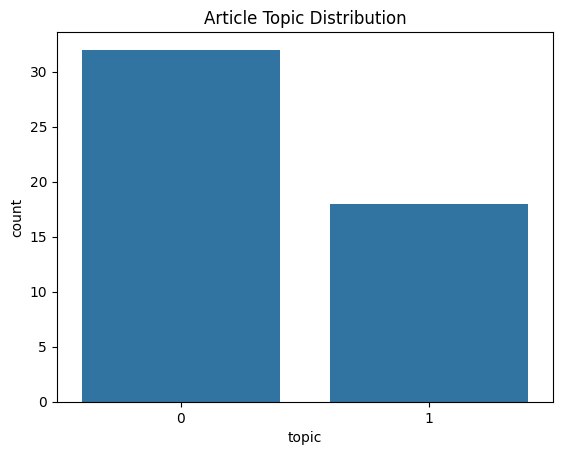

In [9]:
lda = LatentDirichletAllocation(n_components=2, random_state=42)
lda_matrix = lda.fit_transform(tfidf_matrix)

df['topic'] = lda_matrix.argmax(axis=1)

sns.countplot(x='topic', data=df)
plt.title("Article Topic Distribution")
plt.show()


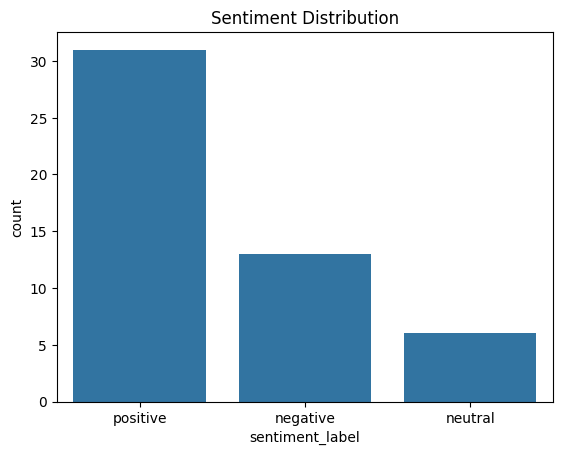

In [10]:
sia = SentimentIntensityAnalyzer()
df['sentiment'] = df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])
df['sentiment_label'] = df['sentiment'].apply(lambda x: 'positive' if x>0 else ('negative' if x<0 else 'neutral'))

sns.countplot(x='sentiment_label', data=df)
plt.title("Sentiment Distribution")
plt.show()


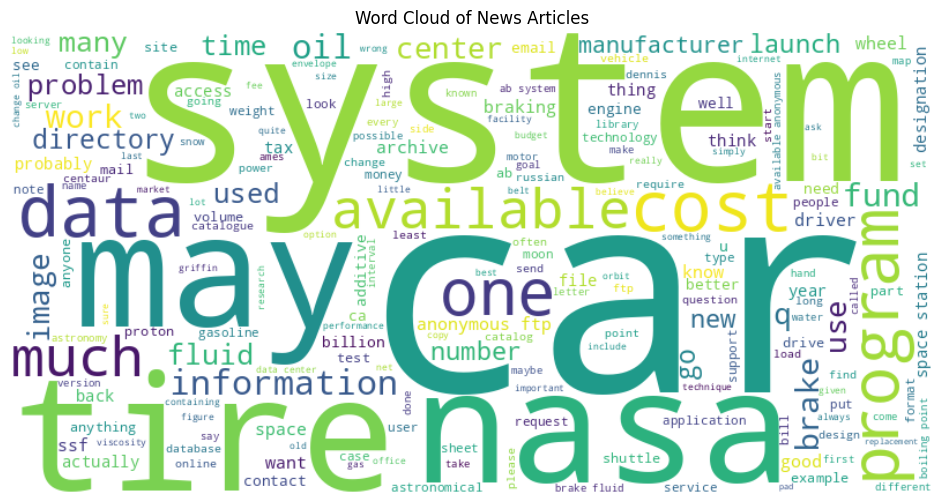

In [11]:
all_text = ' '.join(df['clean_text'])
wc = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of News Articles")
plt.show()
